# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

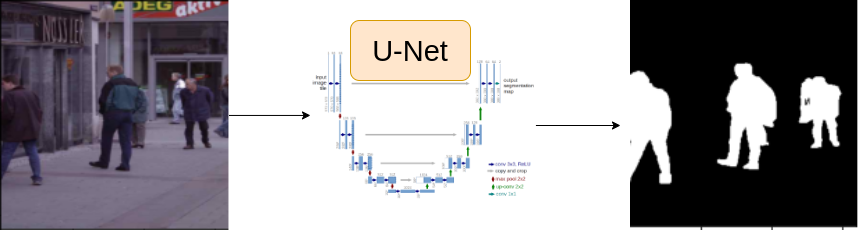

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [99]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [100]:
CSV_FILE = "/content/Human-Segmentation-Dataset-master/train.csv"
DATA_DIR = "/content/"

DEVICE = "cuda"

EPOCHS = 25
BATCH_SIZE = 16
LR = 0.003
IMAGE_SIZE = 320

ENCODER = "timm-efficientnet-b0"
WEIGHTS = "imagenet"

In [101]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [102]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

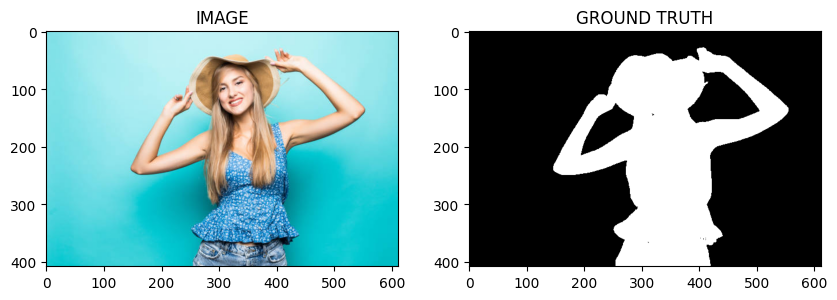

In [103]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [104]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 1234)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [105]:
import albumentations as A

In [106]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ], is_check_shapes=False)


def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [107]:
from torch.utils.data import Dataset

In [108]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    # (h, w, c) => (c, h, w)

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [109]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [110]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


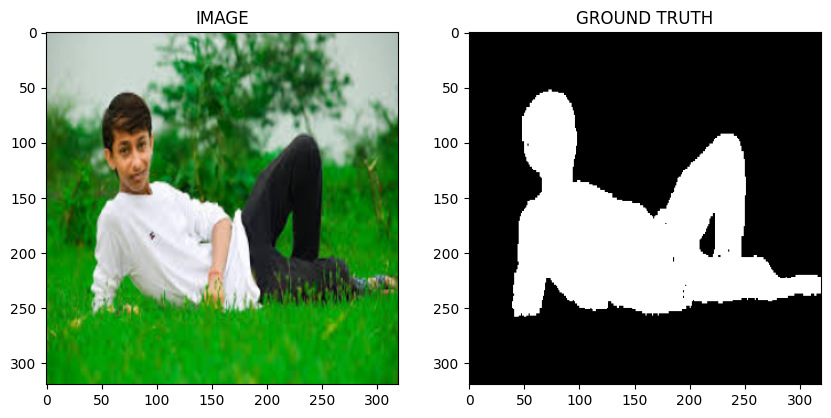

In [111]:
idx = 128
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [112]:
from torch.utils.data import DataLoader

In [113]:
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(validset, batch_size=BATCH_SIZE)

In [114]:
print(f"Total number of batches in train loader: {len(train_loader)}")
print(f"Total number of batches in valid loader: {len(valid_loader)}")

Total number of batches in train loader: 15
Total number of batches in valid loader: 4


In [115]:
for image, mask in train_loader:
  break

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [116]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [130]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks=None):
    logits = self.arc(images)

    if masks is not None:
      loss_1 = DiceLoss(mode='binary')(logits, masks)
      loss_2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss_1 + loss_2

    return logits

In [131]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [132]:
def train_fn(model, dataloader, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)  # Move images to the device
    masks = masks.to(DEVICE)    # Move masks to the device

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    return total_loss / len(dataloader)

In [133]:
def eval_fn(model, dataloader):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
      for images, masks in tqdm(dataloader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        logits, loss = model(images, masks)

        total_loss += loss.item()

  return total_loss / len(dataloader)

# Task 8 : Train Model

In [134]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [135]:
best_valid_loss = np.Inf

for epoch in range(EPOCHS):

  train_loss = train_fn(model, train_loader, optimizer)
  valid_loss = eval_fn(model, valid_loader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    print('SAVED-MODEL')
    best_valid_loss = valid_loss

  print(f"Epoch: {epoch+1}, train_loss: {train_loss}, val_loss: {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


SAVED-MODEL
Epoch: 1, train_loss: 0.0917725404103597, val_loss: 13.587558269500732


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


Epoch: 2, train_loss: 0.08089263439178467, val_loss: 74.262451171875


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


Epoch: 3, train_loss: 0.06594312191009521, val_loss: 57.12622356414795


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch: 4, train_loss: 0.04948592980702718, val_loss: 48.37676429748535


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


Epoch: 5, train_loss: 0.044705426692962645, val_loss: 67.43529605865479


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


SAVED-MODEL
Epoch: 6, train_loss: 0.04921424388885498, val_loss: 9.352324485778809


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


SAVED-MODEL
Epoch: 7, train_loss: 0.03912479480107625, val_loss: 8.920019030570984


100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


Epoch: 8, train_loss: 0.03659629821777344, val_loss: 15.922255039215088


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch: 9, train_loss: 0.024720895290374755, val_loss: 14.02793002128601


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Epoch: 10, train_loss: 0.026117799679438274, val_loss: 11.090753197669983


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


SAVED-MODEL
Epoch: 11, train_loss: 0.02271248698234558, val_loss: 4.60507994890213


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


SAVED-MODEL
Epoch: 12, train_loss: 0.029378279050191244, val_loss: 1.8568163514137268


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


SAVED-MODEL
Epoch: 13, train_loss: 0.03393168449401855, val_loss: 1.089002788066864


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


SAVED-MODEL
Epoch: 14, train_loss: 0.02146906852722168, val_loss: 0.9114950597286224


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Epoch: 15, train_loss: 0.03698842128117879, val_loss: 1.0514846742153168


100%|██████████| 4/4 [00:00<00:00,  4.52it/s]


Epoch: 16, train_loss: 0.02321087121963501, val_loss: 1.2952755391597748


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


Epoch: 17, train_loss: 0.019492552677790324, val_loss: 1.467705488204956


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch: 18, train_loss: 0.015262138843536378, val_loss: 1.452574223279953


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


Epoch: 19, train_loss: 0.03431557416915894, val_loss: 1.14088274538517


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


Epoch: 20, train_loss: 0.02214172085126241, val_loss: 0.9313536435365677


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


Epoch: 21, train_loss: 0.021685194969177247, val_loss: 0.974859356880188


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


Epoch: 22, train_loss: 0.024082533518473306, val_loss: 1.0576758831739426


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch: 23, train_loss: 0.01834020217259725, val_loss: 1.0608499199151993


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Epoch: 24, train_loss: 0.019683708747227985, val_loss: 0.9563388079404831


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]

Epoch: 25, train_loss: 0.04038168986638387, val_loss: 1.0738608688116074


# Task 9 : Inference